Based on https://github.com/UNC-optics/Introduction-to-holography/blob/master/Demo_1_Wave_Propagation.m

In [76]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io, transform

def get_image(image_shape, url):
    data = io.imread(url).astype(float)
    data = np.mean(data, 2)

    data = data - np.min(data)
    data = data / np.max(data)
    data = 1. - data

    data = data / np.sum(data)

    data = transform.resize(data, image_shape)

    return -data

def show_results(Intensity, Amplitude, Phase, z):
    z = round(z, 3)
    fig, axs = plt.subplots(1, 3, figsize=(9, 5), sharey=True, sharex=True)

    axs[0].imshow(Intensity, cmap='gray')
    axs[0].set_xlabel('X [mm]') 
    axs[0].set_ylabel('Y [mm]')
    axs[0].set_title(f'Intensity at z={z}')

    axs[1].imshow(Amplitude, cmap='gray')
    axs[1].set_xlabel('X [mm]') 
    axs[1].set_ylabel('Y [mm]')
    axs[1].set_title(f'Amplitude at z={z}')

    axs[2].imshow(Phase, cmap='gray')
    axs[2].set_xlabel('X [mm]')
    axs[2].set_ylabel('Y [mm]')
    axs[2].set_title(f'Phase at z={z}')

def get_angle_grid(image_shape, pixel_size):
    M, N = image_shape

    UY = np.arange(M)
    UY = UY - np.mean(UY)
    UY -= 1 if M%2 == 1 else .5

    UX = np.arange(N)
    UX = UX - np.mean(UX)
    UX -= 1 if N%2 == 1 else .5

    x, y = np.meshgrid(UX, UY)
    
    # in a discrete fourier transform setting
    # the following are the fractional angles 
    # in the complex circle representing each frequency
    kx = x / pixel_size / N 
    ky = y / pixel_size / M

    return kx, ky

def fresnelDiffraction(amplitude, wavelength, z, kx, ky):
    H = np.exp(-1j * np.pi * wavelength * z * (kx**2 + ky**2))
    H = np.fft.fftshift(H)
    objFT = np.fft.fft2(amplitude)
    field = np.fft.ifft2(objFT * H)
    return field

def get_complex_field(intensity, phase):
    amplitude = np.sqrt(intensity, dtype=complex)
    complex_field = amplitude * np.exp(1j * phase)
    return complex_field

def get_field_parts(complex_field):
    intensity = np.abs(complex_field)**2
    amplitude = np.abs(complex_field)
    phase = np.angle(complex_field)
    return intensity, amplitude, phase

def score(intensity_1, intensity_2):
    # normalize the two input intensity profiles
    intensity_1 = intensity_1 / np.sum(intensity_1)
    intensity_2 = intensity_2 / np.sum(intensity_2)

    # Calculate the error image with an L2 norm
    error_image = (intensity_1 - intensity_2)**2

    # Mean value over the whole image
    score = np.sqrt(np.sum(error_image))
    return score

def two_plane_holography(intensity_1, intensity_2, phase, wavelength, propagation_distance, pixel_size, iterations):
    shape = intensity_1.shape
    kx, ky = get_angle_grid(shape, pixel_size)
    errors = []

    field_1 = get_complex_field(intensity_1, phase)
    for i in range(iterations):
        field_2 = fresnelDiffraction(field_1, wavelength, propagation_distance, kx, ky)
        field_2_intensity = np.abs(field_2)**2
        error = score(intensity_2, field_2_intensity)
        errors.append(error)

        # Enforce the amplitude in field 2, keep the phase
        phase = np.angle(field_2)
        amplitude = np.sqrt(intensity_2, dtype=complex)
        field_2 = amplitude * np.exp(1j * phase)

        # Propagate back to the original plane in z = 0
        field_1 = fresnelDiffraction(field_2, wavelength, -propagation_distance, kx, ky)

        # Enforce the amplitude in field 1, keep the phase
        phase = np.angle(field_1)
        amplitude = np.sqrt(intensity_1, dtype=complex)
        field_1 = amplitude * np.exp(1j * phase)

    return errors, field_1

# Fresnel Diffraction

Fresnel diffraction models how a planar light wave hitting an aperture of arbitrary shape diffuses over a screen placed at a distant $z$ from that aperture.
It takes advantage of the Huygens Principle whereby an aperture can be modelled as a number of point sources each emitting a spherical wave. The intensity of the light hitting any point $(x, y, z)$ on the screen is the sum of the contributions from each of these point sources:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda}\int\int_{-\infty}^{\infty}A(x^{\prime}, y^{\prime}, 0) e^{\frac{ik}{2z}[(x-x^{\prime})^2 + (y - y^{\prime})^2]}dx^{\prime}dy^{\prime}
\end{equation}
where $(x^{\prime}, y^{\prime}, 0)$ is a point on the aperture and $k=\frac{2\pi}{\lambda}$ with $\lambda$ being the wave length.  
The following implementation takes advantage of the observation that the above can be expressed in terms of a [convolution](https://en.wikipedia.org/wiki/Convolution) operation.  
Let $G(x, y, z) = e^{\frac{ik}{2z}(x^2 + y^2)}$, then the Fresnel diffraction may be rewritten as:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} (A*G)(x, y, z)
\end{equation}
The convolution operation $*$ can be turned into a multiplication by applying the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) and switching from the spatial domain to the frequency domain through the application of a *Fourier Transform* $\mathcal{F}$ on both $A$ and $G$. Therefore the final expression becomes:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} \mathcal{F}^{-1}(\mathcal{F}(A)\cdot\mathcal{F}(G))
\end{equation}
where $\mathcal{F}^{-1}$ is the $inverse$ Fourier Transform required in order to get back to the spatial domain.  
Note that after fully computing the inverse transform, the denominator $iz\lambda$ cancels out leaving only the pure $phase$ term $e^{izk}$ which can be disregarded if all we care about is the field value (i.e. the amplitudes).


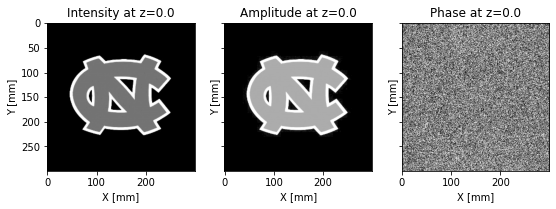

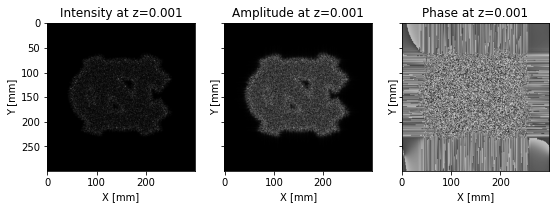

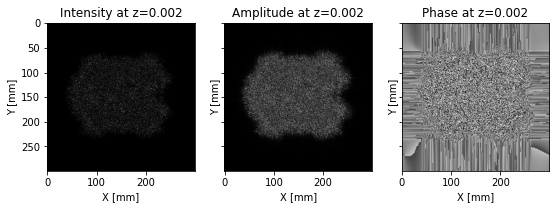

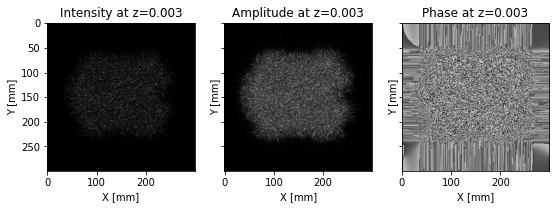

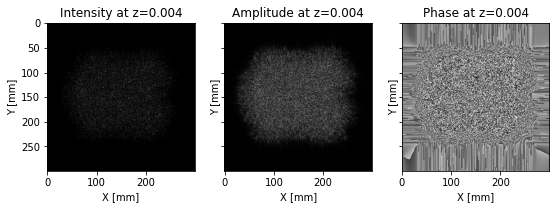

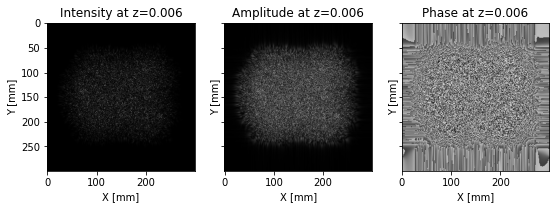

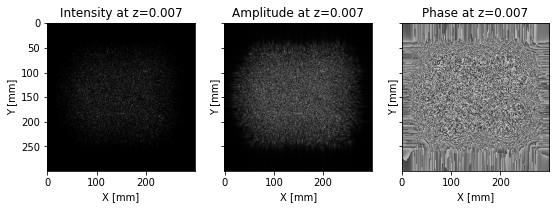

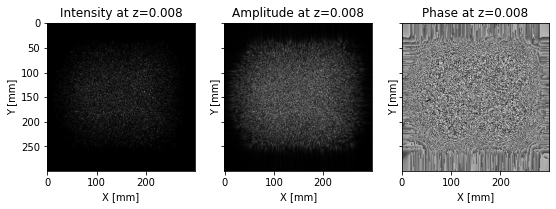

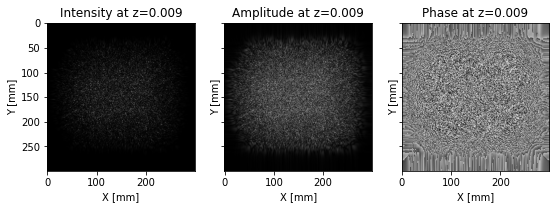

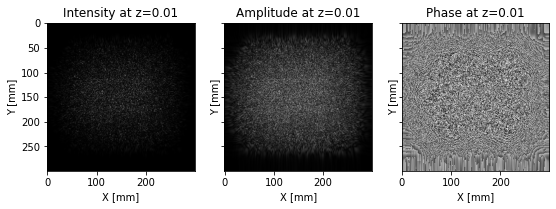

In [77]:
wavelength = 1.0e-6 # meters (1.0 * 10^-6 = 0.0000010) AKA lambda
pixel_size = 10.0e-6 # meters
image_shape = (300, 300)
kx, ky = get_angle_grid(image_shape, pixel_size)

image_url = 'https://raw.githubusercontent.com/UNC-optics/Introduction-to-holography/master/Image1.jpg'
image_intensity = get_image(image_shape, image_url)
phase = 2. * np.pi * np.random.rand(image_shape[0], image_shape[1])
complex_field = get_complex_field(image_intensity, phase)

for propagation_distance_meters in np.linspace(0, 0.01, 10): # 10 equally spaced numbers between 0 and 0.010 inclusive
    new_field = fresnelDiffraction(complex_field, wavelength, propagation_distance_meters, kx, ky)
    intensity, amplitude, phase = get_field_parts(new_field)
    show_results(intensity, amplitude, phase, propagation_distance_meters)

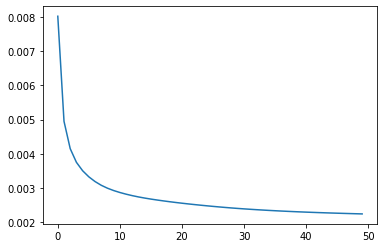

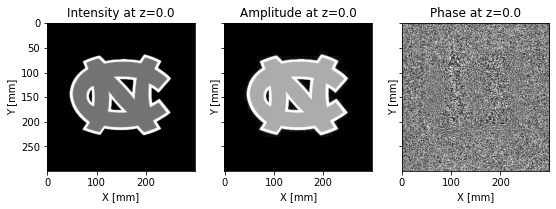

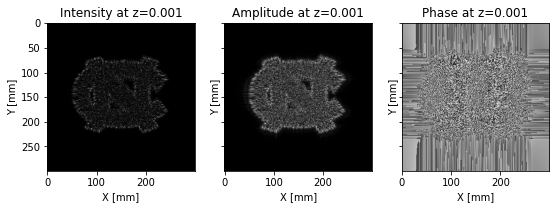

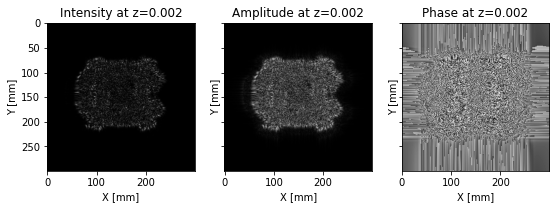

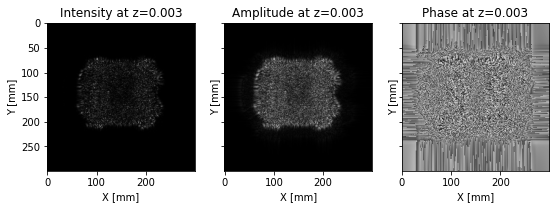

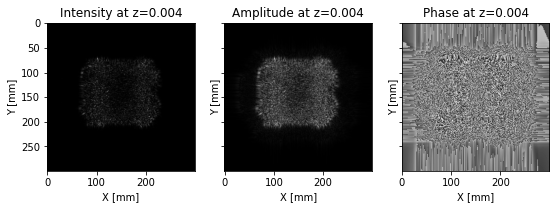

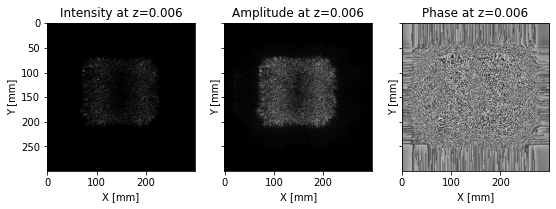

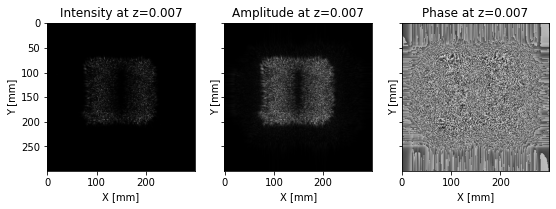

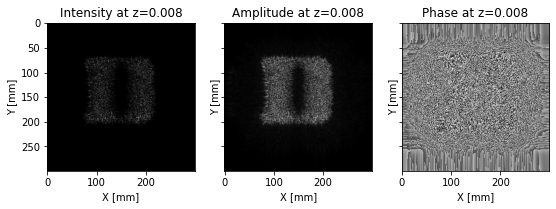

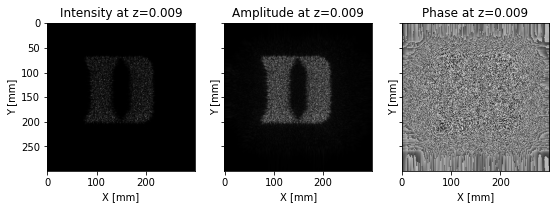

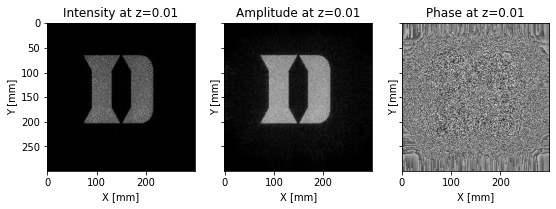

In [78]:
wavelength = 1.0e-6 # meters (1.0 * 10^-6 = 0.0000010) AKA lambda
pixel_size = 10.0e-6 # meters
image_shape = (300, 300)
kx, ky = get_angle_grid(image_shape, pixel_size)
propagation_distance_meters = 0.01

image_1_url = 'https://raw.githubusercontent.com/UNC-optics/Introduction-to-holography/master/Image1.jpg'
intensity_1 = get_image(image_shape, image_1_url)
image_2_url = 'https://raw.githubusercontent.com/UNC-optics/Introduction-to-holography/master/Image2.jpg'
intensity_2 = get_image(image_shape, image_2_url)

phase = 2. * np.pi * np.random.rand(image_shape[0], image_shape[1])

iterations = 50
errors, field_1 = two_plane_holography(intensity_1, intensity_2, phase, wavelength, propagation_distance_meters, pixel_size, iterations)

plt.plot(errors)
plt.show()

# Show results
for z in np.linspace(0, propagation_distance_meters, 10):
    new_field = fresnelDiffraction(field_1, wavelength, z, kx, ky)
    intensity, amplitude, phase = get_field_parts(new_field)
    show_results(intensity, amplitude, phase, z)